# PCE pro Oakwood(3).csv (nsim=100, n_runs=5)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math, warnings, random, re

from scipy import stats as sc
from scipy.stats import lognorm, norm

# UQpy imports (fail gracefully if not installed)
try:
    from UQpy import surrogates, sensitivity, distributions
    from UQpy.surrogates import PolynomialChaosExpansion, TotalDegreeBasis
    from UQpy.sensitivity import PceSensitivity
    from UQpy.distributions import Uniform, Normal, Lognormal, JointIndependent
    from UQpy.surrogates.polynomial_chaos.polynomials.baseclass.Polynomials import Polynomials
    from UQpy.surrogates.polynomial_chaos.regressions.LeastSquareRegression import LeastSquareRegression
    UQPY_AVAILABLE = True
except Exception as e:
    UQPY_AVAILABLE = False
    UQPY_IMPORT_ERROR = e

# Nastavení
nsim = 100        # Počet vstupních simulací pro PCE
n_runs = 5        # Počet průchodů
target_error = 1
CheckOverfitting = True
least_squares = LeastSquareRegression() if UQPY_AVAILABLE else None

print("UQpy dostupné:", UQPY_AVAILABLE)

UQpy dostupné: True


In [2]:
# Načtení a robustní parsování Oakwood(3).csv
path = "Oakwood(3).csv"
raw = pd.read_csv(path, header=None, dtype=str, engine="python")

# Pokud má jediný sloupec, zkus rozdělit podle ';'
if raw.shape[1] == 1:
    df_split = raw.iloc[:, 0].str.split(";", expand=True)
else:
    df_split = raw.copy()

# Detekce hlavičky
first_row = df_split.iloc[0].astype(str)
non_numeric = sum(not re.match(r'^\s*-?\d+(?:[\.,]\d+)?\s*$', str(v)) for v in first_row)
is_header = non_numeric >= df_split.shape[1] * 0.5

if is_header:
    df_split.columns = [str(c).strip() for c in first_row.tolist()]
    df_data = df_split.iloc[1:].reset_index(drop=True)
else:
    df_split.columns = [f"C{idx+1}" for idx in range(df_split.shape[1])]
    df_data = df_split.copy()

# Trim + čárky -> tečky, převod na čísla
df_data = df_data.applymap(lambda x: str(x).strip().replace(",", ".") if pd.notnull(x) else x)
df_num = df_data.apply(pd.to_numeric, errors="coerce")

print("Tvar po parsování:", df_num.shape)
display(df_num.head())

Tvar po parsování: (1000, 35)


,Ec,Rel,Erat_1,E50_1,c_1,phi_1,k0_1,Erat_2,E50_2,c_2,...,U_318_19.2,U_316_19.2,U_315_19.2,U_314_19.2,U_313_19.2,U_312_19.2,U_311_19.2,U_310_19.2,U_308_19.2,U_306_19.2
0,12.5,52.85,2.21,73.9,21.6,29.7,0.619,2.79,135.0,4.29,...,-0.003065,-0.010106,-0.016012,-0.023664,-0.027770,-0.024399,-0.017712,-0.011355,-0.003575,-0.000302
1,13.5,46.30,2.37,59.6,30.9,30.5,0.983,2.02,140.0,3.77,...,-0.003406,-0.011466,-0.017314,-0.025440,-0.029641,-0.026037,-0.018946,-0.012234,-0.003320,-0.000015
2,12.4,43.72,2.96,76.7,31.1,30.0,1.000,2.84,138.0,6.48,...,-0.003434,-0.010287,-0.015514,-0.022710,-0.026571,-0.023541,-0.017364,-0.011221,-0.003486,-0.000451
3,13.6,37.05,2.41,63.7,23.4,30.6,1.050,2.42,124.0,4.09,...,-0.003681,-0.010214,-0.015210,-0.022035,-0.025780,-0.022948,-0.017115,-0.011134,-0.003708,-0.000712
4,13.6,65.04,2.32,63.5,32.8,32.1,0.995,2.99,132.0,5.64,...,-0.003319,-0.009898,-0.014986,-0.021961,-0.025762,-0.022843,-0.016860,-0.010872,-0.003411,-0.000469


In [3]:
# Detekce prvního výstupu ('U_', 'SM_', 'SF')
cols = list(df_data.columns)
def find_first_output_index(cols):
    for i, c in enumerate(cols):
        s = str(c)
        if s.startswith("U_") or s.startswith("SM_") or s.startswith("SF"):
            return i
    return None

first_out_idx = find_first_output_index(cols)
if first_out_idx is None:
    raise RuntimeError("Nebyly nalezeny výstupy (U_/SM_/SF).")

param_columns = cols[:first_out_idx]
output_columns = cols[first_out_idx:]

df_params = df_num[param_columns].copy()
df_u = df_num[output_columns].copy()

# Uložit kontrolní CSV
df_params.to_csv("Oakwood_parameters.csv", index=False)
df_u.to_csv("Oakwood_outputs.csv", index=False)

# Statistika
means = df_num.mean(axis=0)
stds = df_num.std(axis=0, ddof=1)
stats_df = pd.DataFrame({"Sloupec": df_num.columns, "Průměr": means.values, "Směrodatná odchylka": stds.values})
stats_df.to_csv("Oakwood_summary_stats.csv", index=False)

print("Vstupy:", len(param_columns), "| Výstupy:", len(output_columns))
display(stats_df.head())

Vstupy: 12 | Výstupy: 23


,Sloupec,Průměr,Směrodatná odchylka
0,Ec,13.00050,0.999755
1,Rel,49.99998,11.552588
2,Erat_1,2.50000,0.288848
3,E50_1,64.99840,5.008615
4,c_1,30.00010,5.004932


In [4]:
# Vstupní rozdělení (uprav dle potřeby)
if not UQPY_AVAILABLE:
    print("UQpy není dostupné. Přeskočím PCE část. Chyba importu:", UQPY_IMPORT_ERROR)

input_distributions = [
    Normal(loc=13, scale=1),         # Ec (GPa)
    Uniform(loc=30, scale=40),       # Rel % (30-70%)
    Uniform(loc=2, scale=1),         # Erat_1 (2-3)
    Normal(loc=65, scale=5),         # E50_1 (kPa)
    Normal(loc=30, scale=5),         # c_1 (kPa)
    Normal(loc=30, scale=1),         # phi_1 (deg)
    Uniform(loc=0.6, scale=0.5),     # k0_1 (0.6-1.1)
    Uniform(loc=2, scale=1),         # Erat_2 (2-3)
    Normal(loc=130, scale=10),       # E50_2 (kPa)
    Normal(loc=5, scale=1),          # c_2 (kPa)
    Normal(loc=42, scale=1),         # phi_2 (deg)
    Uniform(loc=0.45, scale=0.2)     # k0_2 (0.45-0.65)
] if UQPY_AVAILABLE else []

if UQPY_AVAILABLE:
    joint = JointIndependent(marginals=input_distributions)

n_cols = len(df_u.columns)

In [5]:
# Hlavní smyčka PCE
all_results = []
if UQPY_AVAILABLE:
    for run in range(n_runs):
        print(f"\n Průchod {run+1}/{n_runs}")
        if nsim > len(df_params):
            raise ValueError(f"nsim ({nsim}) je větší než počet dostupných řádků ({len(df_params)}).")
        idx = random.sample(range(len(df_params)), nsim)
        X = df_params.iloc[idx].to_numpy()
        Y = df_u.iloc[idx].to_numpy()

        best_error = np.full(n_cols, np.nan)
        best_val_error = np.full(n_cols, np.nan)
        best_mean = np.full(n_cols, np.nan)
        best_std = np.full(n_cols, np.nan)
        best_params = [None]*n_cols

        err_lar = np.full(n_cols, np.nan)
        err_full = np.full(n_cols, np.nan)
        val_lar = np.full(n_cols, np.nan)
        val_full = np.full(n_cols, np.nan)

        for i, col in enumerate(df_u.columns):
            Y_col = Y[:, i].reshape(-1, 1)

            if np.allclose(Y_col, Y_col[0], atol=1e-12):
                best_params[i] = (1, 1.0)
                best_error[i] = best_val_error[i] = 0.0
                best_mean[i] = float(Y_col[0]); best_std[i] = 0.0
                err_lar[i] = err_full[i] = val_lar[i] = val_full[i] = 0.0
                continue

            best_err = np.inf
            best_model = None

            for p in range(3, 4):
                for q in [0.6, 0.8, 1.0]:
                    try:
                        basis = TotalDegreeBasis(joint, p, hyperbolic=q)
                        if basis.polynomials_number >= 0.9 * len(X):
                            continue

                        pce = PolynomialChaosExpansion(polynomial_basis=basis, regression_method=least_squares)
                        pce.fit(X, Y_col)

                        # LAR
                        try:
                            from UQpy.surrogates.polynomial_chaos.regressions import LeastAngleRegression
                            lar = LeastAngleRegression.model_selection(pce, target_error, CheckOverfitting)
                            e_lar = lar.leaveoneout_error()
                            v_lar = lar.validation_error(X, Y_col)
                        except Exception:
                            e_lar = np.inf; v_lar = np.inf

                        # Full PCE
                        try:
                            e_full = pce.leaveoneout_error()
                            v_full = pce.validation_error(X, Y_col)
                        except Exception:
                            e_full = np.inf; v_full = np.inf

                        err_lar[i] = e_lar if np.isfinite(e_lar) else np.nan
                        err_full[i] = e_full if np.isfinite(e_full) else np.nan
                        val_lar[i] = v_lar if np.isfinite(v_lar) else np.nan
                        val_full[i] = v_full if np.isfinite(v_full) else np.nan

                        chosen, e = (lar, e_lar) if e_lar < e_full else (pce, e_full)
                        if np.isfinite(e) and e < best_err:
                            best_err = e
                            best_model = chosen
                            best_params[i] = (p, q)
                            best_error[i] = e
                            best_val_error[i] = v_lar if chosen is lar else v_full
                    except Exception as exc:
                        print(f"  Error p={p}, q={q} → {exc}")
                        continue

            if best_model is not None:
                m, v = best_model.get_moments()
                best_mean[i] = float(m)
                best_std[i] = float(np.sqrt(v))
            else:
                print(f"⚠️ No stable model found for {df_u.columns[i]}.")

        run_results = pd.DataFrame({
            'column': df_u.columns,
            'p': [bp[0] if bp else None for bp in best_params],
            'q': [bp[1] if bp else None for bp in best_params],
            'LOO_best': best_error,
            'Val_best': best_val_error,
            'mean_PCE': best_mean,
            'std_PCE': best_std,
            'LOO_LAR': err_lar,
            'LOO_full': err_full,
            'Val_LAR': val_lar,
            'Val_full': val_full
        })
        all_results.append(run_results)
else:
    print("UQpy není dostupné – přeskočeno.")


 Průchod 1/5

 Průchod 2/5

 Průchod 3/5

 Průchod 4/5

 Průchod 5/5


,column,mean_LOO_best,mean_Val_best,mean_mean_PCE,mean_std_PCE,mean_LOO_LAR,mean_LOO_full,mean_Val_LAR,mean_Val_full
0,U_251_1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,U_260_1,0.640041,0.490369,0.002466,0.000098,0.640041,1.309636,0.490369,0.398307
2,U_281_1,0.003316,0.002648,-0.003079,0.000991,0.003316,0.006298,0.002648,0.001980
3,U_289_1,0.004636,0.003400,-0.009191,0.000803,0.004636,0.009330,0.003400,0.002665
4,U_295_1,0.005102,0.003367,-0.004462,0.000982,0.005102,0.010212,0.003367,0.002837


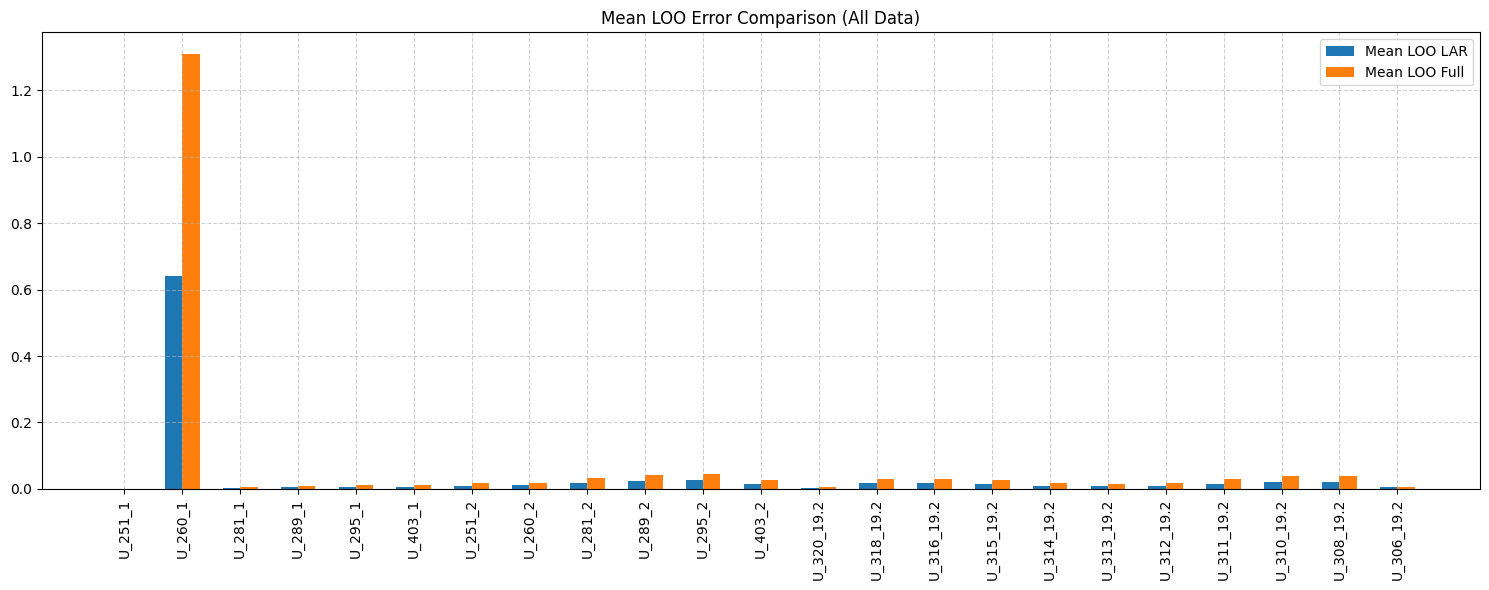

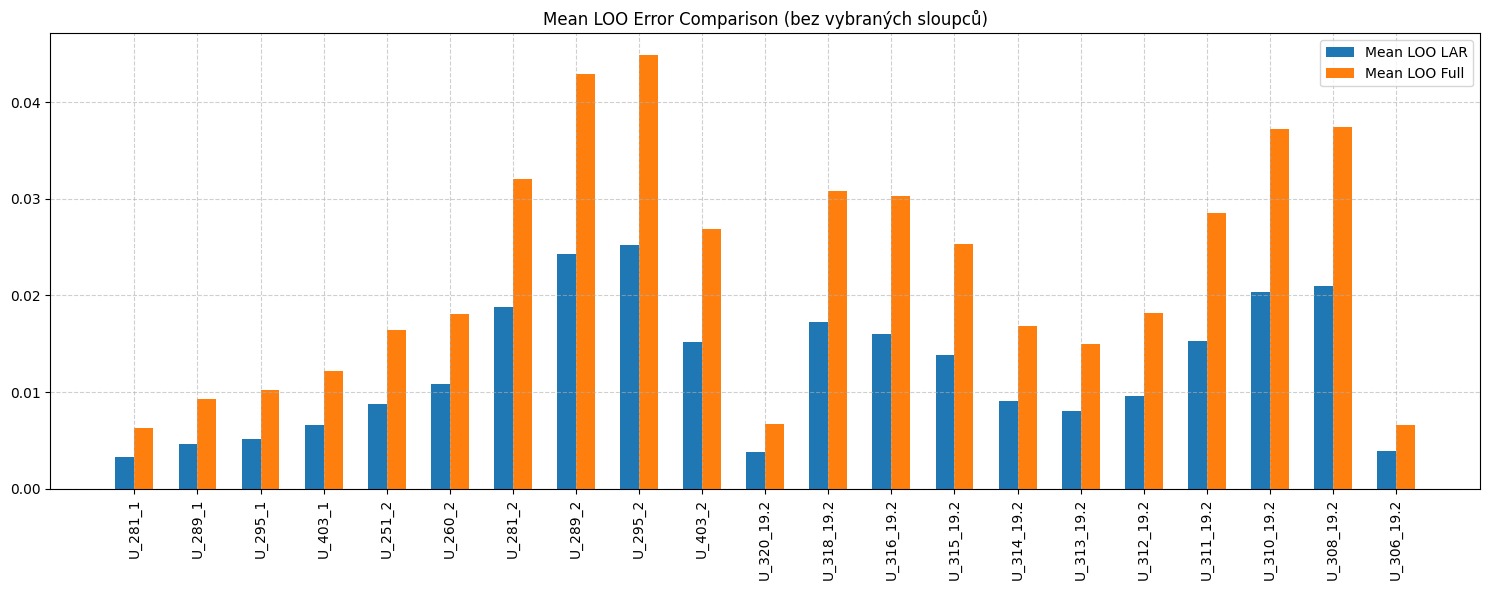

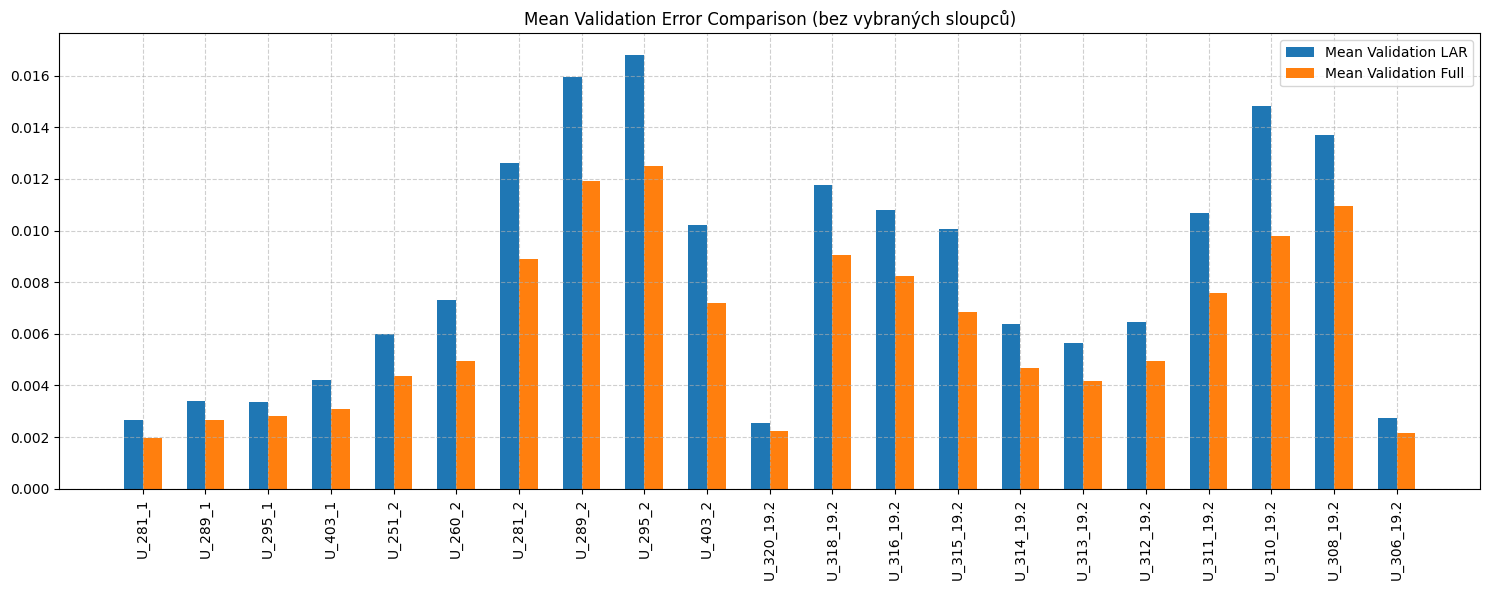

In [6]:
# Agregace průměrů a uložení
if UQPY_AVAILABLE and len(all_results) > 0:
    mean_results = pd.DataFrame({
        'column': df_u.columns,
        'mean_LOO_best': np.nanmean([r['LOO_best'].values for r in all_results], axis=0),
        'mean_Val_best': np.nanmean([r['Val_best'].values for r in all_results], axis=0),
        'mean_mean_PCE': np.nanmean([r['mean_PCE'].values for r in all_results], axis=0),
        'mean_std_PCE': np.nanmean([r['std_PCE'].values for r in all_results], axis=0),
        'mean_LOO_LAR': np.nanmean([r['LOO_LAR'].values for r in all_results], axis=0),
        'mean_LOO_full': np.nanmean([r['LOO_full'].values for r in all_results], axis=0),
        'mean_Val_LAR': np.nanmean([r['Val_LAR'].values for r in all_results], axis=0),
        'mean_Val_full': np.nanmean([r['Val_full'].values for r in all_results], axis=0),
    })
    mean_results.to_csv("Oakwood_mean_results.csv", index=False)
    display(mean_results.head())

    # Ploty
    w = 0.3
    x = np.arange(len(df_u.columns))

    plt.figure(figsize=(15, 6))
    plt.bar(x - w/2, mean_results['mean_LOO_LAR'], w, label='Mean LOO LAR')
    plt.bar(x + w/2, mean_results['mean_LOO_full'], w, label='Mean LOO Full')
    plt.xticks(x, df_u.columns, rotation=90)
    plt.title('Mean LOO Error Comparison (All Data)')
    plt.legend(); plt.grid(True, linestyle='--', alpha=0.6); plt.tight_layout()
    plt.savefig("Oakwood_plot_mean_LOO_all.png", dpi=200)
    plt.show()

    exclude_cols = [c for c in ['U_260_1', 'U_251_1'] if c in df_u.columns]
    valid_cols = [col for col in df_u.columns if col not in exclude_cols]
    valid_idx = [list(df_u.columns).index(c) for c in valid_cols]

    plt.figure(figsize=(15, 6))
    plt.bar(np.arange(len(valid_cols)) - w/2, mean_results['mean_LOO_LAR'].values[valid_idx], w, label='Mean LOO LAR')
    plt.bar(np.arange(len(valid_cols)) + w/2, mean_results['mean_LOO_full'].values[valid_idx], w, label='Mean LOO Full')
    plt.xticks(np.arange(len(valid_cols)), valid_cols, rotation=90)
    plt.title('Mean LOO Error Comparison (bez vybraných sloupců)')
    plt.legend(); plt.grid(True, linestyle='--', alpha=0.6); plt.tight_layout()
    plt.savefig("Oakwood_plot_mean_LOO_filtered.png", dpi=200)
    plt.show()

    plt.figure(figsize=(15, 6))
    plt.bar(np.arange(len(valid_cols)) - w/2, mean_results['mean_Val_LAR'].values[valid_idx], w, label='Mean Validation LAR')
    plt.bar(np.arange(len(valid_cols)) + w/2, mean_results['mean_Val_full'].values[valid_idx], w, label='Mean Validation Full')
    plt.xticks(np.arange(len(valid_cols)), valid_cols, rotation=90)
    plt.title('Mean Validation Error Comparison (bez vybraných sloupců)')
    plt.legend(); plt.grid(True, linestyle='--', alpha=0.6); plt.tight_layout()
    plt.savefig("Oakwood_plot_mean_val_filtered.png", dpi=200)
    plt.show()
else:
    print("Mean results neexistují (PCE neproběhlo).")